In [1]:
# run from suite2p environment!!
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import scipy.io as sio
import sys
sys.path.append('../helpers')
import loadmat as lm
from sklearn import linear_model
from scipy import signal
from sklearn.model_selection import cross_val_score, cross_validate
import os
from sklearn.metrics import make_scorer
import glob
from sklearn.metrics import mean_absolute_error
import seaborn as sns


In [62]:
files = glob.glob('Z:/giocomo/attialex/NP_DATA/*_contrast_*.mat')
for iF in files:
    print(iF)

Z:/giocomo/attialex/NP_DATA\npF3_1019_contrasttrack_gainchanges_contrast_1.mat
Z:/giocomo/attialex/NP_DATA\npH1_0312_contrast_1.mat
Z:/giocomo/attialex/NP_DATA\npH1_0313_contrast_2.mat
Z:/giocomo/attialex/NP_DATA\npH3_0330_contrast_2.mat
Z:/giocomo/attialex/NP_DATA\npH4_0319_contrast_2.mat
Z:/giocomo/attialex/NP_DATA\npH5_0324_contrast_1.mat
Z:/giocomo/attialex/NP_DATA\npI1_0414_contrast_2.mat
Z:/giocomo/attialex/NP_DATA\npI3_0421_contrast_1.mat
Z:/giocomo/attialex/NP_DATA\npI4_0421_contrast_2.mat
Z:/giocomo/attialex/NP_DATA\npI5_0414_contrast_1.mat
Z:/giocomo/attialex/NP_DATA\npJ1_0521_contrast_1.mat
Z:/giocomo/attialex/NP_DATA\npJ2_0512_contrast_1.mat
Z:/giocomo/attialex/NP_DATA\npJ3_0506_contrast_1.mat
Z:/giocomo/attialex/NP_DATA\npJ4_0512_contrast_1.mat
Z:/giocomo/attialex/NP_DATA\npJ5_0505_contrast_1.mat


In [33]:
def preprocess(data):
    track_start = 0
    track_end = 400
    dx=5
    dt=0.2
    every_nth_time_bin = 10
    numposbins = np.floor((track_end-track_start)/dx)
    posx_edges = np.linspace(track_start,track_end,numposbins+1)
    posx=data['posx']
    post=data['post']
    trial = data['trial']
    sp =  data['sp']
    
    # resample post, posx, and trial according to desired dt
    post_resampled = post[0::every_nth_time_bin]
    posx_resampled = posx[0::every_nth_time_bin]
    trial_resampled = trial[0::every_nth_time_bin]

    # get cell ids of "good" units
    good_cells = sp['cids'][sp['cgs']==2]

    # time bins for position decoding
    numtimebins = len(post_resampled)
    post_edges = np.squeeze(np.linspace(min(post)-dt/2,max(post)+dt/2,numtimebins+1))
    post_centers = post_edges[range(0,len(post_edges)-1)]+dt/2

    # posx categories for position decoding (binned)
    posx_bin = np.digitize(posx_resampled,posx_edges)

    # count spikes in each time bin for each cell
    spikecount = np.empty((len(good_cells),len(post_resampled),))
    spikecount[:] = np.nan
    for cell_idx in range(len(good_cells)):   
        spike_t = sp['st'][sp['clu']==good_cells[cell_idx]]
        spikecount[cell_idx,:] = np.histogram(spike_t,bins=post_edges)[0]
    data['spikecount']=np.transpose(spikecount)
    data['posx_bin']=posx_bin
    data['trial_resampled']=trial_resampled
    return data

In [14]:
test_data = lm.loadmat(files[1])

In [34]:
test_data = preprocess(test_data)

C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


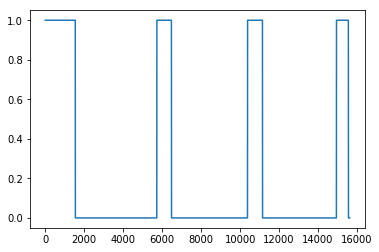

In [55]:
bl_trials = np.nonzero(np.all([test_data['trial_contrast']==100, test_data['trial_gain']==1],axis = 0))
trialidx = np.isin(test_data['trial_resampled'],bl_trials)
plt.plot(trialidx)

C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


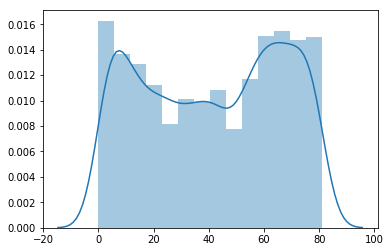

In [58]:
sns.distplot(test_data['posx_bin'][trialidx])

In [44]:
model = linear_model.LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000, C = 0.1)
model.fit(test_data['spikecount'][trialidx,:],test_data['posx_bin'][trialidx])

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
for iC in [100, 50, 20, 10, 5, 2, 0]:
    bl_trials = np.nonzero(np.all([test_data['trial_contrast']==iC, test_data['trial_gain']==1],axis = 0))
    trialidx = np.isin(test_data['trial_resampled'],bl_trials)
    #print(model.score(test_data['spikecount'][trialidx,:],test_data['posx_bin'][trialidx]))
    Yhat = model.predict(test_data['spikecount'][trialidx,:])
    print(mean_absolute_error(Yhat,test_data['posx_bin'][trialidx]))

5.503810560696788
11.713483146067416
16.429962141698216
20.492970946579195
23.317238267148014
24.760679079956187
26.6131090487239


In [78]:
def eval_and_train(dataset):
    bl_trials = np.nonzero(np.all([dataset['trial_contrast']==100, dataset['trial_gain']==1],axis = 0))
    trialidx = np.isin(dataset['trial_resampled'],bl_trials)
    scoring = {'prec_macro': 'precision_macro','mae_macro': make_scorer(mean_absolute_error)}
    model = linear_model.LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000, C = 0.1)
    #scores = cross_val_score(model, , cv=5)
    scores = cross_validate(model,dataset['spikecount'][trialidx,:],dataset['posx_bin'][trialidx],scoring=scoring, cv=5,return_estimator=True)
    
    model = linear_model.LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000, C = 0.1)
    model.fit(dataset['spikecount'][trialidx,:],dataset['posx_bin'][trialidx])
    return model,scores

In [54]:
eval_and_train(test_data)

C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: Undef

(LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=10000,
                    multi_class='multinomial', n_jobs=None, penalty='l2',
                    random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 {'fit_time': array([12.47268939, 12.93744898, 14.31776309, 10.12196851, 13.46304488]),
  'score_time': array([0.00897741, 0.00199437, 0.00299096, 0.00199389, 0.00199509]),
  'estimator': (LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=10000,
                      multi_class='multinomial', n_jobs=None, penalty='l2',
                      random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                      warm_start=False),
   LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ra

In [101]:
def score_baseline_model(model,test_data):
    errors = []
    precision = []
    for iC in [100, 50, 20, 10, 5, 2, 0]:
        

        bl_trials = np.nonzero(np.all([test_data['trial_contrast']==iC, test_data['trial_gain']==1],axis = 0))
        trialidx = np.isin(test_data['trial_resampled'],bl_trials)
        if trialidx.sum()>0:
            #print(model.score(test_data['spikecount'][trialidx,:],test_data['posx_bin'][trialidx]))
            Yhat = model.predict(test_data['spikecount'][trialidx,:])
            errors.append(mean_absolute_error(Yhat,test_data['posx_bin'][trialidx]))
            precision.append(model.score(test_data['spikecount'][trialidx,:],test_data['posx_bin'][trialidx]))
        else: 
            errors.append(np.nan)
            precision.append(np.nan)
        
        
    return (errors,precision)

In [71]:
score_baseline_model(model,test_data)

([5.503810560696788,
  11.713483146067416,
  16.429962141698216,
  20.492970946579195,
  23.317238267148014,
  24.760679079956187,
  26.6131090487239],
 [0.562874251497006,
  0.15355805243445692,
  0.09085992428339643,
  0.05248359887535145,
  0.04061371841155235,
  0.01588170865279299,
  0.015661252900232018])

In [103]:
files = glob.glob('Z:/giocomo/attialex/NP_DATA/*_contrast_*.mat')
contrast_scores = []
baseline_scores = []
for iF in files:
    dataset = lm.loadmat(iF)
    dataset = preprocess(dataset)
    (model, bl_scores) = eval_and_train(dataset)
    tmp_scores = score_baseline_model(model,dataset)
    contrast_scores.append(tmp_scores)
    baseline_scores.append(bl_scores)


C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.

C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  

C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.

C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [134]:
bl_scores = [np.mean(x['test_mae_macro']) for x in baseline_scores]
bl_scores

[6.105191624791323,
 11.368046450180511,
 8.038788247003644,
 9.054329910387901,
 14.260322227697145,
 16.880404552420174,
 13.514170963740213,
 9.88286088953805,
 11.467449323463635,
 13.192427209251028,
 11.016028530317246,
 12.309810463039666,
 13.094371147915567,
 13.23634667471731,
 10.286974968159402]

In [112]:
contrast_error = [x[0] for x in contrast_scores]
ee=np.array(contrast_error)
ee.shape

(15, 7)

In [136]:
bb={str(e):ee[:,iC] for iC,e in enumerate([100, 50, 20, 10, 5, 2, 0])}
bb['100']=bl_scores
import pandas as pd
bb=pd.DataFrame(bb)

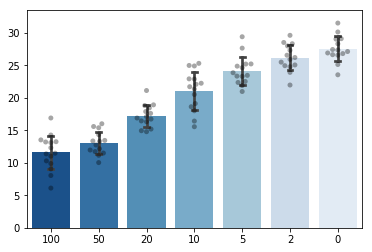

In [138]:
sns.barplot(data=bb, capsize=.1, ci="sd",palette="Blues_r")
ax=sns.swarmplot(data=bb, color="0", alpha=.35)
plt.savefig('C:/temp/out_error_contrast.pdf')